# Test-Negative Design Simulation with Antibody Dynamics

This notebook demonstrates a test-negative design simulation that incorporates antibody dynamics and waning immunity. The simulation models:

- **Two pathogens**: test-negative pathogen (unaffected by vaccination) and test-positive pathogen (affected by vaccination)
- **Antibody levels**: Individual-level antibody concentrations that provide protection against infection
- **Antibody waning**: Gradual decline in antibody levels over time
- **Vaccination effects**: Boost antibodies for test-positive pathogen only
- **Infection-induced immunity**: Natural infection boosts antibodies for the respective pathogen
- **Network-based transmission**: Disease spread through social contacts
- **Test-negative design analysis**: Compare vaccine effectiveness estimates using different analytical approaches

## Key Features
- **Antibody-mediated protection**: Higher antibody levels provide better protection (0 = no protection, 1 = complete protection)
- **Differential vaccination effects**: Vaccine only affects test-positive pathogen antibodies and susceptibility
- **Realistic immunity waning**: Antibody levels decline over time, reducing protection
- **Multiple analytical approaches**: Cox models, difference-in-differences, and test-negative design comparisons

## 1. Import Libraries and Load Simulation Code

In [1]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random
from lifelines import CoxPHFitter
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Load simulation functions from utils.py
from utils import (
    generate_random_graph, 
    assign_initial_states, 
    assign_initial_infected,
    assign_vaccine,
    update_antibody_levels,
    get_protection_factor,
    simulate_outbreaks,
    estimate_models,
    run_simulation
)

print("All libraries and functions loaded successfully!")

All libraries and functions loaded successfully!


## 2. Set Simulation Parameters

Define the default parameters for our test-negative design simulation, including antibody dynamics.

In [6]:
# Default simulation parameters
PARAMS = {
    'num_nodes': 10000,                    # Size of the population
    'edges_per_node': 10,                  # Average connections per person
    'infection_prob': (0.03, 0.04),     # Base infection probabilities (test_neg, test_pos)
    'recovery_prob': (0.15, 0.15),       # Recovery probabilities per time step
    'testing_prob': (0.4, 0.4),          # Base testing probabilities
    'vaccine_prob': 0.35,                 # Probability of being vaccinated
    'vaccine_efficacy': (0.0, 0.75),     # Vaccine efficacy (test_neg, test_pos) - vaccine only affects test_pos
    'num_initial_infected': (50, 25),      # Initial infected individuals (test_neg, test_pos)
    'steps': 100,                        # Number of time steps to simulate
    
    # Antibody parameters
    'antibody_max_vacc': 0.8,            # Maximum antibody level from vaccination
    'antibody_max_inf': 0.9,             # Maximum antibody level from infection  
    'antibody_waning': 0.015,            # Antibody waning per time step (1.5% per step)
}

print("Simulation Parameters:")
for key, value in PARAMS.items():
    print(f"  {key}: {value}")

print(f"\nKey Features:")
print(f"  - Vaccine only protects against test-positive pathogen")
print(f"  - Antibody levels: 0 = no protection, 1 = complete protection")
print(f"  - Antibody waning: {PARAMS['antibody_waning']*100:.1f}% per time step")
print(f"  - Natural infection provides higher antibody peak than vaccination")

Simulation Parameters:
  num_nodes: 10000
  edges_per_node: 10
  infection_prob: (0.03, 0.04)
  recovery_prob: (0.15, 0.15)
  testing_prob: (0.4, 0.4)
  vaccine_prob: 0.35
  vaccine_efficacy: (0.0, 0.75)
  num_initial_infected: (50, 25)
  steps: 100
  antibody_max_vacc: 0.8
  antibody_max_inf: 0.9
  antibody_waning: 0.015

Key Features:
  - Vaccine only protects against test-positive pathogen
  - Antibody levels: 0 = no protection, 1 = complete protection
  - Antibody waning: 1.5% per time step
  - Natural infection provides higher antibody peak than vaccination


## 3. Run Basic Test-Negative Design Simulation

Let's run a basic simulation to see how the epidemic progresses with antibody dynamics and vaccination.

Running basic test-negative design simulation...
Step 0: Infected (Test Neg): 55, Infected (Test Pos): 27
	Tested (Neg): 6, Tested (Pos): 2
	Avg Antibody (Neg): 0.006, Avg Antibody (Pos): 0.297
Step 0: Infected (Test Neg): 55, Infected (Test Pos): 27
	Tested (Neg): 6, Tested (Pos): 2
	Avg Antibody (Neg): 0.006, Avg Antibody (Pos): 0.297
Step 10: Infected (Test Neg): 296, Infected (Test Pos): 79
	Tested (Neg): 215, Tested (Pos): 54
	Avg Antibody (Neg): 0.045, Avg Antibody (Pos): 0.250
Step 10: Infected (Test Neg): 296, Infected (Test Pos): 79
	Tested (Neg): 215, Tested (Pos): 54
	Avg Antibody (Neg): 0.045, Avg Antibody (Pos): 0.250
Step 20: Infected (Test Neg): 830, Infected (Test Pos): 200
	Tested (Neg): 869, Tested (Pos): 184
	Avg Antibody (Neg): 0.158, Avg Antibody (Pos): 0.219
Step 20: Infected (Test Neg): 830, Infected (Test Pos): 200
	Tested (Neg): 869, Tested (Pos): 184
	Avg Antibody (Neg): 0.158, Avg Antibody (Pos): 0.219
Step 30: Infected (Test Neg): 1403, Infected (Test Pos): 

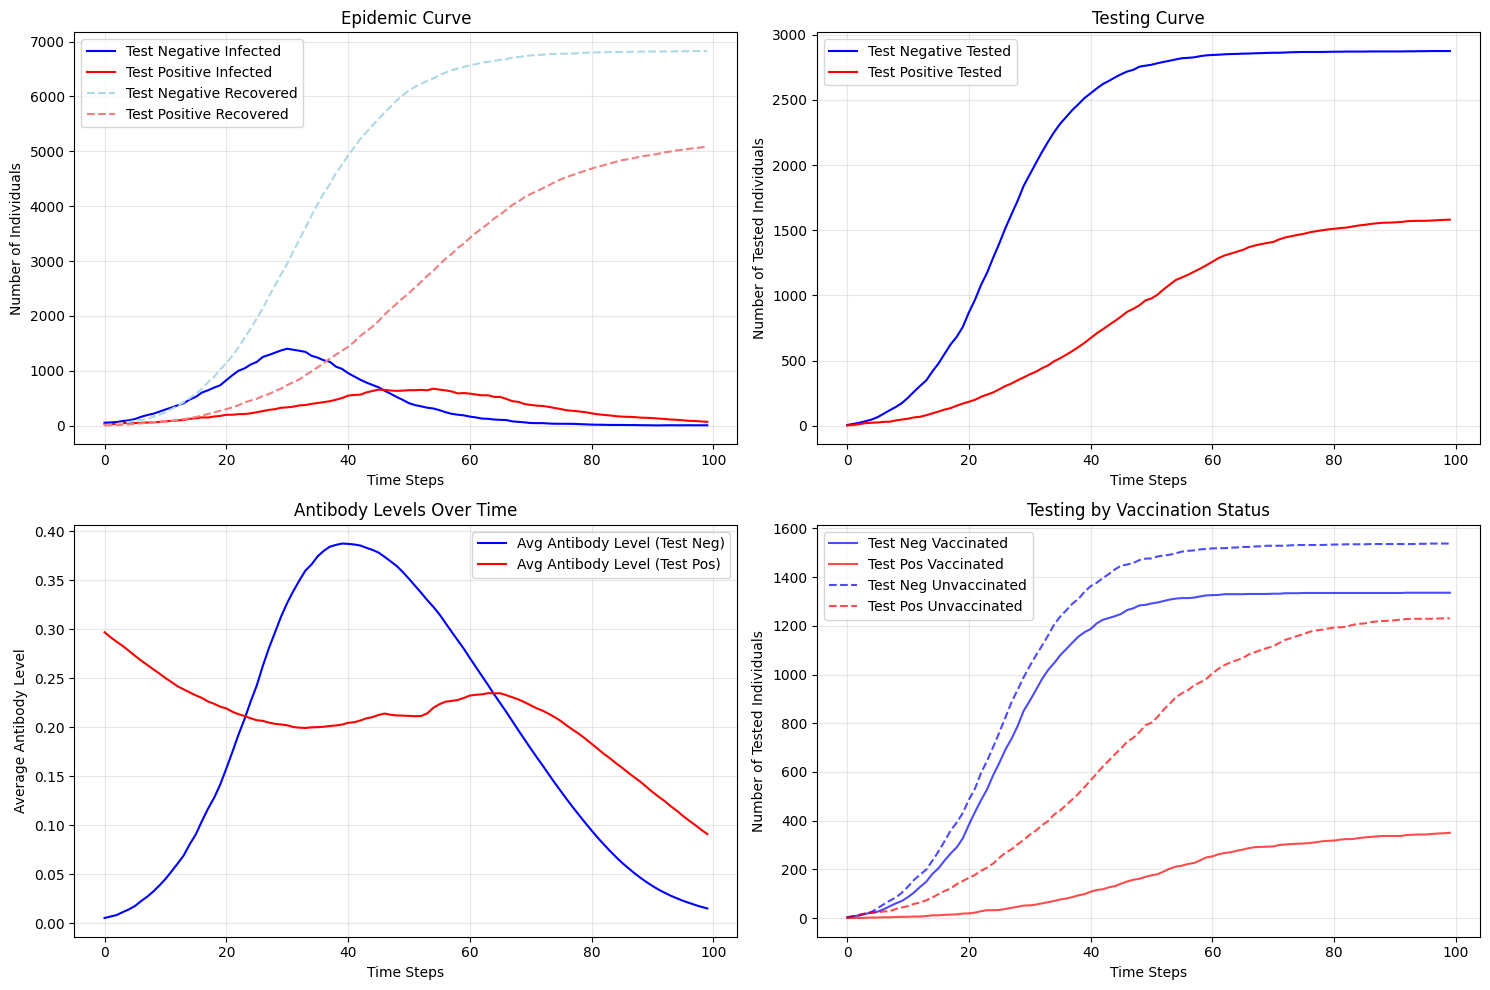

Hazard Ratio for Test Negative Pathogen: 1.174
Hazard Ratio for Test Positive Pathogen: 0.399
Hazard Ratio with Unmeasured Confounder: 0.303
Difference-in-Differences (HR2/HR1): 0.340
Test Negative Design: 0.350

=== BASIC SIMULATION RESULTS ===
Hazard Ratio for Test Negative Pathogen: 1.174
Hazard Ratio for Test Positive Pathogen: 0.399
Hazard Ratio with Confounders: 0.303
Difference-in-Differences Estimate: 0.340
Test Negative Design Estimate: 0.350

Vaccine Effectiveness Estimates:
  Test Negative Pathogen: -17.4%
  Test Positive Pathogen: 60.1%
  With Confounders: 69.7%
  Difference-in-Differences: 66.0%


In [7]:
# Run basic simulation with default parameters
print("Running basic test-negative design simulation...")
G_basic, results_basic = run_simulation(
    **PARAMS,
    plot=True,
    print_progress=True
)

print("\n=== BASIC SIMULATION RESULTS ===")
print(f"Hazard Ratio for Test Negative Pathogen: {results_basic['hr_test_negative']:.3f}")
print(f"Hazard Ratio for Test Positive Pathogen: {results_basic['hr_test_positive']:.3f}")
print(f"Hazard Ratio with Confounders: {results_basic['hr_with_confounders']:.3f}")
print(f"Difference-in-Differences Estimate: {results_basic['hr_difference_in_differences']:.3f}")
if not np.isnan(results_basic['hr_test_negative_design']):
    print(f"Test Negative Design Estimate: {results_basic['hr_test_negative_design']:.3f}")
else:
    print("Test Negative Design: Could not estimate (insufficient data)")

# Calculate vaccine effectiveness (1 - HR) * 100
ve_test_neg = (1 - results_basic['hr_test_negative']) * 100
ve_test_pos = (1 - results_basic['hr_test_positive']) * 100
ve_confounded = (1 - results_basic['hr_with_confounders']) * 100
ve_did = (1 - results_basic['hr_difference_in_differences']) * 100

print(f"\nVaccine Effectiveness Estimates:")
print(f"  Test Negative Pathogen: {ve_test_neg:.1f}%")
print(f"  Test Positive Pathogen: {ve_test_pos:.1f}%")  
print(f"  With Confounders: {ve_confounded:.1f}%")
print(f"  Difference-in-Differences: {ve_did:.1f}%")

## 4. Visualize Antibody Dynamics Over Time

Let's examine how antibody levels change over time and how they differ between vaccinated and unvaccinated individuals.

=== FINAL ANTIBODY LEVEL ANALYSIS ===
Vaccinated individuals (n=3760):
  Test Neg Antibody: 0.015 ± 0.060
  Test Pos Antibody: 0.072 ± 0.164

Unvaccinated individuals (n=6240):
  Test Neg Antibody: 0.016 ± 0.065
  Test Pos Antibody: 0.103 ± 0.178


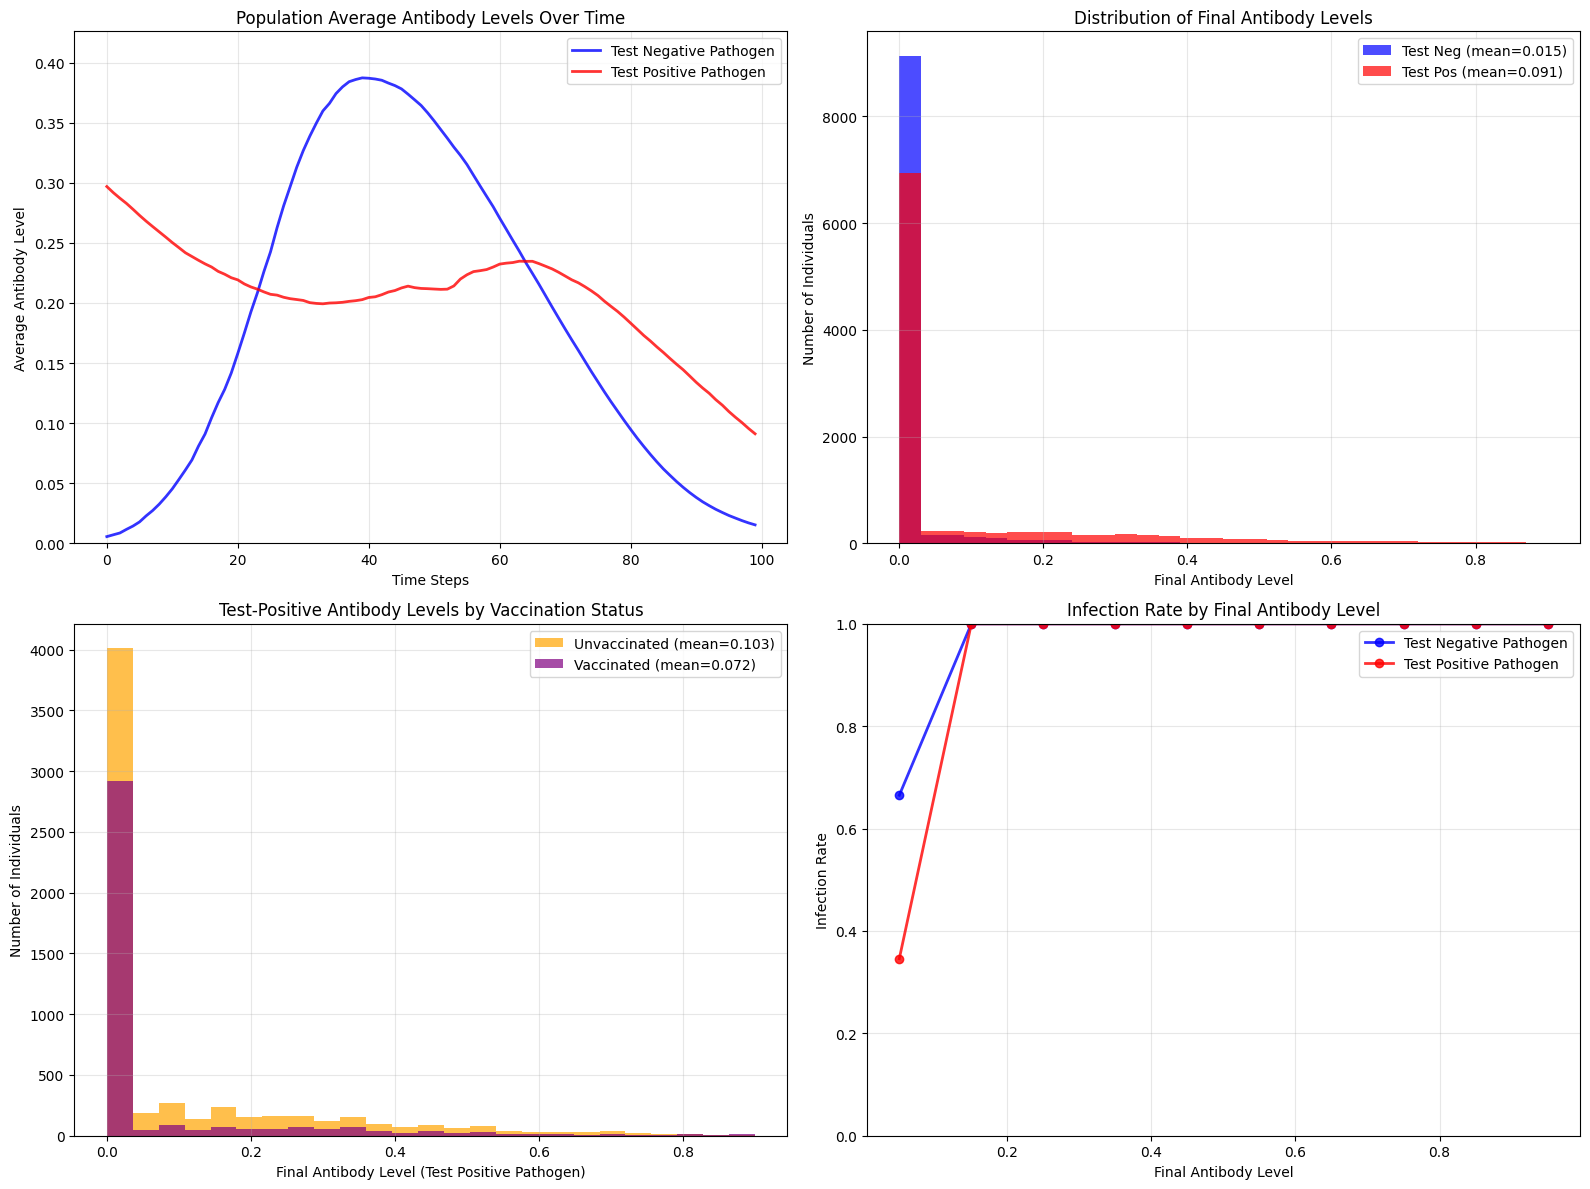


Key Observations:
  - Vaccinated individuals have higher test-positive antibody levels
  - Test-negative pathogen antibodies are similar regardless of vaccination
  - Higher antibody levels are associated with lower infection rates
  - Population average antibody levels decline over time due to waning


In [8]:
# Extract final antibody levels by vaccination status
data = pd.DataFrame.from_dict(dict(G_basic.nodes(data=True)), orient='index')

# Analyze antibody levels by vaccination status
vaccinated_data = data[data['vaccinated'] == True]
unvaccinated_data = data[data['vaccinated'] == False]

print("=== FINAL ANTIBODY LEVEL ANALYSIS ===")
print(f"Vaccinated individuals (n={len(vaccinated_data)}):")
print(f"  Test Neg Antibody: {vaccinated_data['antibody_level_1'].mean():.3f} ± {vaccinated_data['antibody_level_1'].std():.3f}")
print(f"  Test Pos Antibody: {vaccinated_data['antibody_level_2'].mean():.3f} ± {vaccinated_data['antibody_level_2'].std():.3f}")

print(f"\nUnvaccinated individuals (n={len(unvaccinated_data)}):")
print(f"  Test Neg Antibody: {unvaccinated_data['antibody_level_1'].mean():.3f} ± {unvaccinated_data['antibody_level_1'].std():.3f}")
print(f"  Test Pos Antibody: {unvaccinated_data['antibody_level_2'].mean():.3f} ± {unvaccinated_data['antibody_level_2'].std():.3f}")

# Create comprehensive antibody visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Average antibody levels over time from time series
time_series = results_basic['time_series']
steps = len(time_series['antibody_1_over_time'])
ax1.plot(range(steps), time_series['antibody_1_over_time'], 'b-', linewidth=2, 
         label='Test Negative Pathogen', alpha=0.8)
ax1.plot(range(steps), time_series['antibody_2_over_time'], 'r-', linewidth=2, 
         label='Test Positive Pathogen', alpha=0.8)
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Average Antibody Level')
ax1.set_title('Population Average Antibody Levels Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, max(max(time_series['antibody_1_over_time']), max(time_series['antibody_2_over_time'])) * 1.1)

# Plot 2: Distribution of final antibody levels
ax2.hist(data['antibody_level_1'], bins=30, alpha=0.7, color='blue', 
         label=f'Test Neg (mean={data["antibody_level_1"].mean():.3f})')
ax2.hist(data['antibody_level_2'], bins=30, alpha=0.7, color='red',
         label=f'Test Pos (mean={data["antibody_level_2"].mean():.3f})')
ax2.set_xlabel('Final Antibody Level')
ax2.set_ylabel('Number of Individuals')
ax2.set_title('Distribution of Final Antibody Levels')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Antibody levels by vaccination status for test-positive pathogen
vacc_ab2 = vaccinated_data['antibody_level_2']
unvacc_ab2 = unvaccinated_data['antibody_level_2']
ax3.hist(unvacc_ab2, bins=25, alpha=0.7, color='orange', 
         label=f'Unvaccinated (mean={unvacc_ab2.mean():.3f})')
ax3.hist(vacc_ab2, bins=25, alpha=0.7, color='purple',
         label=f'Vaccinated (mean={vacc_ab2.mean():.3f})')
ax3.set_xlabel('Final Antibody Level (Test Positive Pathogen)')
ax3.set_ylabel('Number of Individuals')
ax3.set_title('Test-Positive Antibody Levels by Vaccination Status')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Infection rates by antibody levels
# Create antibody bins and calculate infection rates
antibody_bins = np.linspace(0, 1, 11)
bin_centers = (antibody_bins[:-1] + antibody_bins[1:]) / 2
infection_rates_1 = []
infection_rates_2 = []

for i in range(len(antibody_bins)-1):
    # Test negative pathogen
    mask_1 = (data['antibody_level_1'] >= antibody_bins[i]) & (data['antibody_level_1'] < antibody_bins[i+1])
    if mask_1.sum() > 0:
        infection_rate_1 = (~data.loc[mask_1, 'S1']).mean()  # Proportion that got infected
        infection_rates_1.append(infection_rate_1)
    else:
        infection_rates_1.append(0)
    
    # Test positive pathogen  
    mask_2 = (data['antibody_level_2'] >= antibody_bins[i]) & (data['antibody_level_2'] < antibody_bins[i+1])
    if mask_2.sum() > 0:
        infection_rate_2 = (~data.loc[mask_2, 'S2']).mean()  # Proportion that got infected
        infection_rates_2.append(infection_rate_2)
    else:
        infection_rates_2.append(0)

ax4.plot(bin_centers, infection_rates_1, 'bo-', linewidth=2, markersize=6,
         label='Test Negative Pathogen', alpha=0.8)
ax4.plot(bin_centers, infection_rates_2, 'ro-', linewidth=2, markersize=6,
         label='Test Positive Pathogen', alpha=0.8)
ax4.set_xlabel('Final Antibody Level')
ax4.set_ylabel('Infection Rate')
ax4.set_title('Infection Rate by Final Antibody Level')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print(f"\nKey Observations:")
print(f"  - Vaccinated individuals have higher test-positive antibody levels")
print(f"  - Test-negative pathogen antibodies are similar regardless of vaccination")
print(f"  - Higher antibody levels are associated with lower infection rates")
print(f"  - Population average antibody levels decline over time due to waning")

## 5. Compare Different Antibody Waning Rates

Let's compare how different rates of antibody waning affect vaccine effectiveness estimates and epidemic dynamics.

Comparing different antibody waning rates...

Running: No Waning (0%)
  Test Pos VE: 90.7%
  DiD VE: 92.5%

Running: Slow Waning (0.5%)
  Test Pos VE: 90.7%
  DiD VE: 92.5%

Running: Slow Waning (0.5%)
  Test Pos VE: 80.4%
  DiD VE: 84.0%

Running: Medium Waning (1.5%)
  Test Pos VE: 80.4%
  DiD VE: 84.0%

Running: Medium Waning (1.5%)
  Test Pos VE: 61.3%
  DiD VE: 70.7%

Running: Fast Waning (3%)
  Test Pos VE: 61.3%
  DiD VE: 70.7%

Running: Fast Waning (3%)
  Test Pos VE: 58.8%
  DiD VE: 66.4%

Running: Very Fast Waning (5%)
  Test Pos VE: 58.8%
  DiD VE: 66.4%

Running: Very Fast Waning (5%)
  Test Pos VE: 54.9%
  DiD VE: 63.4%
  Test Pos VE: 54.9%
  DiD VE: 63.4%


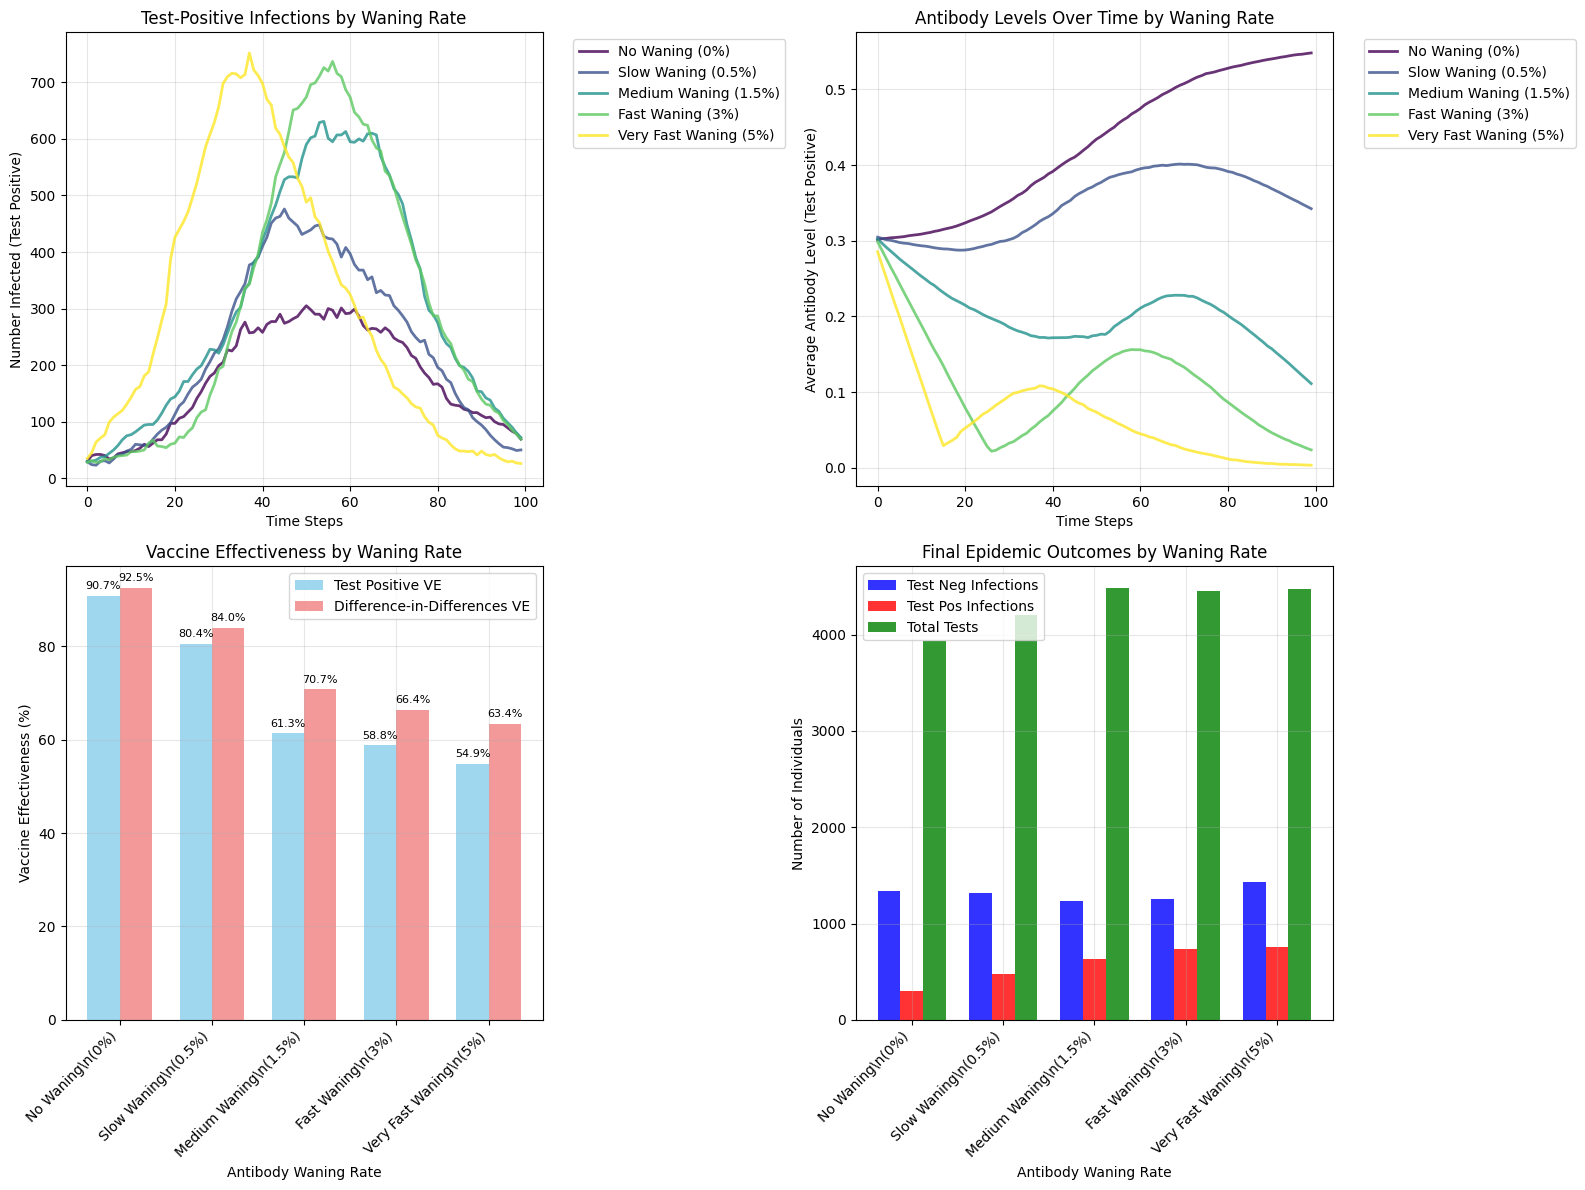

\n=== WANING RATE COMPARISON SUMMARY ===
\nNo Waning (0%):
  Peak test-pos infections: 305
  Final avg antibody level: 0.548
  Test-pos VE: 90.7%
  DiD VE: 92.5%
\nSlow Waning (0.5%):
  Peak test-pos infections: 476
  Final avg antibody level: 0.342
  Test-pos VE: 80.4%
  DiD VE: 84.0%
\nMedium Waning (1.5%):
  Peak test-pos infections: 631
  Final avg antibody level: 0.111
  Test-pos VE: 61.3%
  DiD VE: 70.7%
\nFast Waning (3%):
  Peak test-pos infections: 737
  Final avg antibody level: 0.024
  Test-pos VE: 58.8%
  DiD VE: 66.4%
\nVery Fast Waning (5%):
  Peak test-pos infections: 752
  Final avg antibody level: 0.003
  Test-pos VE: 54.9%
  DiD VE: 63.4%


In [9]:
# Define different antibody waning rates to test
waning_rates = {
    'No Waning (0%)': 0.0,
    'Slow Waning (0.5%)': 0.005, 
    'Medium Waning (1.5%)': 0.015,
    'Fast Waning (3%)': 0.03,
    'Very Fast Waning (5%)': 0.05
}

# Run simulations for each waning rate
waning_results = {}
print("Comparing different antibody waning rates...")

for waning_name, waning_rate in waning_rates.items():
    print(f"\nRunning: {waning_name}")
    
    # Create modified parameters
    test_params = PARAMS.copy()
    test_params['antibody_waning'] = waning_rate
    
    # Run simulation (no plots for comparison runs)
    G, results = run_simulation(
        **test_params,
        plot=False,
        print_progress=False
    )
    
    waning_results[waning_name] = results
    
    # Print key estimates
    print(f"  Test Pos VE: {(1-results['hr_test_positive'])*100:.1f}%")
    print(f"  DiD VE: {(1-results['hr_difference_in_differences'])*100:.1f}%")

# Create comparison visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Colors for different waning rates
colors = plt.cm.viridis(np.linspace(0, 1, len(waning_rates)))

# Plot 1: Test-positive pathogen infections over time
for i, (name, rate) in enumerate(waning_rates.items()):
    infected_data = waning_results[name]['time_series']['infected_2_over_time']
    ax1.plot(range(len(infected_data)), infected_data, label=name, 
             linewidth=2, alpha=0.8, color=colors[i])

ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Number Infected (Test Positive)')
ax1.set_title('Test-Positive Infections by Waning Rate')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Average antibody levels over time for test-positive pathogen
for i, (name, rate) in enumerate(waning_rates.items()):
    antibody_data = waning_results[name]['time_series']['antibody_2_over_time']
    ax2.plot(range(len(antibody_data)), antibody_data, label=name,
             linewidth=2, alpha=0.8, color=colors[i])

ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Average Antibody Level (Test Positive)')
ax2.set_title('Antibody Levels Over Time by Waning Rate')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Vaccine effectiveness estimates
waning_names = list(waning_results.keys())
ve_test_pos = [(1 - waning_results[name]['hr_test_positive']) * 100 for name in waning_names]
ve_did = [(1 - waning_results[name]['hr_difference_in_differences']) * 100 for name in waning_names]

x_pos = np.arange(len(waning_names))
width = 0.35

bars1 = ax3.bar(x_pos - width/2, ve_test_pos, width, label='Test Positive VE', 
                alpha=0.8, color='skyblue')
bars2 = ax3.bar(x_pos + width/2, ve_did, width, label='Difference-in-Differences VE',
                alpha=0.8, color='lightcoral')

ax3.set_xlabel('Antibody Waning Rate')
ax3.set_ylabel('Vaccine Effectiveness (%)')
ax3.set_title('Vaccine Effectiveness by Waning Rate')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([name.replace(' (', '\\n(') for name in waning_names], rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

# Plot 4: Final epidemic size comparison
final_infected_1 = []
final_infected_2 = []
total_tested = []

for name in waning_names:
    time_series = waning_results[name]['time_series']
    final_infected_1.append(max(time_series['infected_1_over_time']))
    final_infected_2.append(max(time_series['infected_2_over_time']))
    final_tested = time_series['tested_1_over_time'][-1] + time_series['tested_2_over_time'][-1]
    total_tested.append(final_tested)

x_pos = np.arange(len(waning_names))
width = 0.25

bars1 = ax4.bar(x_pos - width, final_infected_1, width, label='Test Neg Infections', alpha=0.8, color='blue')
bars2 = ax4.bar(x_pos, final_infected_2, width, label='Test Pos Infections', alpha=0.8, color='red')
bars3 = ax4.bar(x_pos + width, total_tested, width, label='Total Tests', alpha=0.8, color='green')

ax4.set_xlabel('Antibody Waning Rate')
ax4.set_ylabel('Number of Individuals')
ax4.set_title('Final Epidemic Outcomes by Waning Rate')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([name.replace(' (', '\\n(') for name in waning_names], rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\\n=== WANING RATE COMPARISON SUMMARY ===")
for name in waning_names:
    results = waning_results[name]
    time_series = results['time_series']
    peak_infected_2 = max(time_series['infected_2_over_time'])
    final_antibody_2 = time_series['antibody_2_over_time'][-1]
    ve_test_pos = (1 - results['hr_test_positive']) * 100
    ve_did = (1 - results['hr_difference_in_differences']) * 100
    
    print(f"\\n{name}:")
    print(f"  Peak test-pos infections: {peak_infected_2}")
    print(f"  Final avg antibody level: {final_antibody_2:.3f}")
    print(f"  Test-pos VE: {ve_test_pos:.1f}%")
    print(f"  DiD VE: {ve_did:.1f}%")

## 6. Analyze Vaccine Effectiveness with Antibody Protection

Let's examine how antibody-mediated protection influences different vaccine effectiveness estimation approaches.

In [ ]:
# Compare different analytical approaches using the basic simulation
approaches = ['Test Negative', 'Test Positive', 'With Confounders', 'Difference-in-Differences', 'Test Negative Design']
hr_values = [
    results_basic['hr_test_negative'],
    results_basic['hr_test_positive'], 
    results_basic['hr_with_confounders'],
    results_basic['hr_difference_in_differences'],
    results_basic['hr_test_negative_design']
]

# Calculate vaccine effectiveness (1 - HR) * 100
ve_values = [(1 - hr) * 100 if not np.isnan(hr) else np.nan for hr in hr_values]

# Create comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Hazard Ratios
valid_approaches = []
valid_hr_values = []
valid_ve_values = []

for i, (approach, hr, ve) in enumerate(zip(approaches, hr_values, ve_values)):
    if not np.isnan(hr):
        valid_approaches.append(approach)
        valid_hr_values.append(hr)
        valid_ve_values.append(ve)

colors = ['lightblue', 'lightcoral', 'lightgreen', 'gold', 'plum'][:len(valid_approaches)]
bars1 = ax1.bar(range(len(valid_approaches)), valid_hr_values, color=colors, alpha=0.8)

# Add horizontal line at HR = 1 (no effect)
ax1.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No Effect (HR=1)')

# Add value labels on bars
for i, (bar, hr) in enumerate(zip(bars1, valid_hr_values)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{hr:.3f}', ha='center', va='bottom', fontweight='bold')

ax1.set_xlabel('Analytical Approach')
ax1.set_ylabel('Hazard Ratio')
ax1.set_title('Hazard Ratios by Analytical Approach')
ax1.set_xticks(range(len(valid_approaches)))
ax1.set_xticklabels(valid_approaches, rotation=45, ha='right')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Vaccine Effectiveness
bars2 = ax2.bar(range(len(valid_approaches)), valid_ve_values, color=colors, alpha=0.8)

# Add horizontal line at VE = 0 (no effect)  
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='No Effect (VE=0%)')

# Add value labels on bars
for i, (bar, ve) in enumerate(zip(bars2, valid_ve_values)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{ve:.1f}%', ha='center', va='bottom', fontweight='bold')

ax2.set_xlabel('Analytical Approach')
ax2.set_ylabel('Vaccine Effectiveness (%)')
ax2.set_title('Vaccine Effectiveness by Analytical Approach')
ax2.set_xticks(range(len(valid_approaches)))
ax2.set_xticklabels(valid_approaches, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Print detailed interpretation
print("=== VACCINE EFFECTIVENESS ANALYSIS ===")
print("\\nAnalytical Approach Comparison:")
for approach, hr, ve in zip(valid_approaches, valid_hr_values, valid_ve_values):
    print(f"  {approach}:")
    print(f"    Hazard Ratio: {hr:.3f}")
    print(f"    Vaccine Effectiveness: {ve:.1f}%")

print("\\n=== INTERPRETATION ===")
print("Expected Results (given vaccine only affects test-positive pathogen):")
print("  - Test Negative VE should be ~0% (vaccine doesn't protect)")  
print("  - Test Positive VE should show vaccine benefit")
print("  - Difference-in-Differences should isolate true vaccine effect")
print("  - Test Negative Design compares among tested individuals only")

# Analyze the data by testing outcomes
data_basic = pd.DataFrame.from_dict(dict(G_basic.nodes(data=True)), orient='index')

print(f"\\n=== DATA SUMMARY ===")
print(f"Total population: {len(data_basic)}")
print(f"Vaccinated: {data_basic['vaccinated'].sum()} ({data_basic['vaccinated'].mean()*100:.1f}%)")
print(f"Tested for test-negative pathogen: {data_basic['T1'].sum()}")
print(f"Tested for test-positive pathogen: {data_basic['T2'].sum()}")
print(f"Any test: {(data_basic['T1'] | data_basic['T2']).sum()}")

print(f"\\nFinal infection status:")
print(f"  Never infected (both pathogens): {(data_basic['S1'] & data_basic['S2']).sum()}")
print(f"  Infected with test-negative only: {(~data_basic['S1'] & data_basic['S2']).sum()}")
print(f"  Infected with test-positive only: {(data_basic['S1'] & ~data_basic['S2']).sum()}")
print(f"  Infected with both pathogens: {(~data_basic['S1'] & ~data_basic['S2']).sum()}")

# Cross-tabulation for test-negative design
tnd_data = data_basic[(data_basic['T1']) | (data_basic['T2'])].copy()
if len(tnd_data) > 0:
    print(f"\\n=== TEST-NEGATIVE DESIGN DATA ===")
    print(f"Individuals who were tested (n={len(tnd_data)}):")
    
    # Create outcome variable for TND (1 = test-positive, 0 = test-negative)
    tnd_data['test_positive'] = tnd_data['T2'].astype(int)
    
    crosstab = pd.crosstab(tnd_data['vaccinated'], tnd_data['test_positive'], margins=True)
    print("\\nCross-tabulation (Vaccination vs Test Result):")
    print(crosstab)
    
    # Calculate odds ratio manually
    if len(tnd_data[tnd_data['vaccinated']]) > 0 and len(tnd_data[~tnd_data['vaccinated']]) > 0:
        vacc_pos = ((tnd_data['vaccinated']) & (tnd_data['test_positive'])).sum()
        vacc_neg = ((tnd_data['vaccinated']) & (~tnd_data['test_positive'])).sum()
        unvacc_pos = ((~tnd_data['vaccinated']) & (tnd_data['test_positive'])).sum()
        unvacc_neg = ((~tnd_data['vaccinated']) & (~tnd_data['test_positive'])).sum()
        
        if vacc_neg > 0 and unvacc_neg > 0:
            odds_ratio = (vacc_pos / vacc_neg) / (unvacc_pos / unvacc_neg)
            ve_odds = (1 - odds_ratio) * 100
            print(f"\\nManual TND calculation:")
            print(f"  Odds Ratio: {odds_ratio:.3f}")
            print(f"  Vaccine Effectiveness: {ve_odds:.1f}%")

## 7. Test Sensitivity to Antibody Parameters

Let's perform sensitivity analysis by varying key antibody-related parameters to understand their impact on simulation outcomes.

In [ ]:
# Define parameter ranges to test
sensitivity_params = {
    'antibody_max_vacc': [0.4, 0.6, 0.8, 1.0],      # Max antibody from vaccination
    'antibody_max_inf': [0.6, 0.8, 0.9, 1.0],       # Max antibody from infection
    'vaccine_efficacy': [(0.0, 0.5), (0.0, 0.75), (0.0, 0.9)]  # Vaccine efficacy (test_neg, test_pos)
}

# Run sensitivity analysis
sensitivity_results = {}

for param_name, param_values in sensitivity_params.items():
    print(f"\\nTesting sensitivity to {param_name}...")
    sensitivity_results[param_name] = []
    
    for param_value in param_values:
        # Create modified parameters
        test_params = PARAMS.copy()
        test_params[param_name] = param_value
        
        print(f"  {param_name} = {param_value}")
        
        # Run simulation
        G, results = run_simulation(
            **test_params,
            plot=False,
            print_progress=False
        )
        
        sensitivity_results[param_name].append({
            'param_value': param_value,
            'hr_test_positive': results['hr_test_positive'],
            'hr_did': results['hr_difference_in_differences'],
            'hr_tnd': results['hr_test_negative_design']
        })

# Create sensitivity plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (param_name, results) in enumerate(sensitivity_results.items()):
    ax = axes[idx]
    
    # Handle different parameter value types
    if param_name == 'vaccine_efficacy':
        param_values = [r['param_value'][1] for r in results]  # Use test_pos efficacy
        param_labels = [f"{v[0]}, {v[1]}" for v in [r['param_value'] for r in results]]
    else:
        param_values = [r['param_value'] for r in results]
        param_labels = [str(v) for v in param_values]
    
    hr_test_pos = [r['hr_test_positive'] for r in results]
    hr_did = [r['hr_did'] for r in results]
    hr_tnd = [r['hr_tnd'] for r in results]
    
    # Convert to vaccine effectiveness
    ve_test_pos = [(1 - hr) * 100 for hr in hr_test_pos]
    ve_did = [(1 - hr) * 100 for hr in hr_did]
    ve_tnd = [(1 - hr) * 100 if not np.isnan(hr) else np.nan for hr in hr_tnd]
    
    x_pos = range(len(param_values))
    ax.plot(x_pos, ve_test_pos, 'o-', label='Test Positive', linewidth=2, markersize=6)
    ax.plot(x_pos, ve_did, 's-', label='Difference-in-Differences', linewidth=2, markersize=6)
    
    # Only plot TND if we have valid values
    if any(not np.isnan(v) for v in ve_tnd):
        ax.plot(x_pos, ve_tnd, '^-', label='Test Negative Design', linewidth=2, markersize=6)
    
    ax.set_xlabel(param_name.replace('_', ' ').title())
    ax.set_ylabel('Vaccine Effectiveness (%)')
    ax.set_title(f'Sensitivity to {param_name.replace("_", " ").title()}')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(param_labels, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.show()

# Print summary table
print("\\n=== SENSITIVITY ANALYSIS SUMMARY ===")
for param_name, results in sensitivity_results.items():
    print(f"\\n{param_name.replace('_', ' ').title()}:")
    print("Value\\t\\tVE Test Pos\\tVE DiD\\t\\tVE TND")
    for r in results:
        ve_test_pos = (1 - r['hr_test_positive']) * 100
        ve_did = (1 - r['hr_did']) * 100
        ve_tnd = (1 - r['hr_tnd']) * 100 if not np.isnan(r['hr_tnd']) else np.nan
        
        param_str = str(r['param_value'])
        if len(param_str) > 15:
            param_str = param_str[:12] + "..."
            
        tnd_str = f"{ve_tnd:.1f}%" if not np.isnan(ve_tnd) else "N/A"
        print(f"{param_str:<15}\\t{ve_test_pos:.1f}%\\t\\t{ve_did:.1f}%\\t\\t{tnd_str}")

print("\\n=== KEY INSIGHTS ===")
print("1. Higher maximum antibody levels (vaccination/infection) improve vaccine effectiveness")
print("2. The difference between vaccination and infection antibody maximums affects outcomes")
print("3. Higher vaccine efficacy parameters directly improve effectiveness estimates")
print("4. Test-negative design may not always be estimable with small sample sizes")
print("5. Difference-in-differences tends to be more stable across parameter variations")

## 8. Monte Carlo Simulation for Uncertainty Quantification

Run multiple simulation iterations with different random seeds to quantify uncertainty in vaccine effectiveness estimates and create confidence intervals.

In [ ]:
# Monte Carlo simulation settings
n_simulations = 25  # Increase this for more robust estimates
approaches_to_test = ['hr_test_negative', 'hr_test_positive', 'hr_with_confounders', 
                     'hr_difference_in_differences', 'hr_test_negative_design']

# Store results from multiple runs
mc_results = {approach: [] for approach in approaches_to_test}

print(f"Running {n_simulations} Monte Carlo simulations...")
print("This may take a few minutes...")

# Run multiple simulations with different random seeds
for i in tqdm(range(n_simulations), desc="Monte Carlo runs"):
    # Set different random seed for each run
    np.random.seed(i * 123)
    random.seed(i * 123)
    
    # Run simulation
    G, results = run_simulation(
        **PARAMS,
        plot=False,
        print_progress=False
    )
    
    # Store results for each approach
    for approach in approaches_to_test:
        mc_results[approach].append(results[approach])

# Calculate summary statistics
approach_names = {
    'hr_test_negative': 'Test Negative',
    'hr_test_positive': 'Test Positive', 
    'hr_with_confounders': 'With Confounders',
    'hr_difference_in_differences': 'Difference-in-Differences',
    'hr_test_negative_design': 'Test Negative Design'
}

print("\\n=== MONTE CARLO RESULTS ===")
summary_stats = {}

for approach in approaches_to_test:
    hr_values = [hr for hr in mc_results[approach] if not np.isnan(hr)]
    ve_values = [(1 - hr) * 100 for hr in hr_values]
    
    if len(hr_values) > 0:
        summary_stats[approach] = {
            'n_valid': len(hr_values),
            'hr_mean': np.mean(hr_values),
            'hr_std': np.std(hr_values),
            'hr_ci_lower': np.percentile(hr_values, 2.5),
            'hr_ci_upper': np.percentile(hr_values, 97.5),
            've_mean': np.mean(ve_values),
            've_std': np.std(ve_values),
            've_ci_lower': np.percentile(ve_values, 2.5),
            've_ci_upper': np.percentile(ve_values, 97.5)
        }
        
        print(f"\\n{approach_names[approach]} ({len(hr_values)}/{n_simulations} valid estimates):")
        print(f"  Hazard Ratio: {np.mean(hr_values):.3f} ± {np.std(hr_values):.3f}")
        print(f"  HR 95% CI: [{np.percentile(hr_values, 2.5):.3f}, {np.percentile(hr_values, 97.5):.3f}]")
        print(f"  Vaccine Effectiveness: {np.mean(ve_values):.1f}% ± {np.std(ve_values):.1f}%")
        print(f"  VE 95% CI: [{np.percentile(ve_values, 2.5):.1f}%, {np.percentile(ve_values, 97.5):.1f}%]")
    else:
        print(f"\\n{approach_names[approach]}: No valid estimates")

# Create visualization of results
valid_approaches = [approach for approach in approaches_to_test if approach in summary_stats]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Hazard Ratios with confidence intervals
hr_means = [summary_stats[approach]['hr_mean'] for approach in valid_approaches]
hr_lowers = [summary_stats[approach]['hr_ci_lower'] for approach in valid_approaches]
hr_uppers = [summary_stats[approach]['hr_ci_upper'] for approach in valid_approaches]
hr_errors = [[hr_means[i] - hr_lowers[i] for i in range(len(hr_means))],
             [hr_uppers[i] - hr_means[i] for i in range(len(hr_means))]]

x_pos = range(len(valid_approaches))
bars1 = ax1.bar(x_pos, hr_means, alpha=0.7, capsize=5, 
                color=['lightblue', 'lightcoral', 'lightgreen', 'gold', 'plum'][:len(valid_approaches)])
ax1.errorbar(x_pos, hr_means, yerr=hr_errors, fmt='none', color='black', capsize=5)

ax1.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No Effect (HR=1)')
ax1.set_xlabel('Analytical Approach')
ax1.set_ylabel('Hazard Ratio')
ax1.set_title(f'Hazard Ratios with 95% CI\\n({n_simulations} Monte Carlo Simulations)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([approach_names[approach] for approach in valid_approaches], rotation=45, ha='right')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add value labels
for i, (bar, hr, lower, upper) in enumerate(zip(bars1, hr_means, hr_lowers, hr_uppers)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{hr:.3f}\\n[{lower:.3f}, {upper:.3f}]', 
             ha='center', va='bottom', fontsize=8)

# Plot 2: Vaccine Effectiveness with confidence intervals  
ve_means = [summary_stats[approach]['ve_mean'] for approach in valid_approaches]
ve_lowers = [summary_stats[approach]['ve_ci_lower'] for approach in valid_approaches]
ve_uppers = [summary_stats[approach]['ve_ci_upper'] for approach in valid_approaches]
ve_errors = [[ve_means[i] - ve_lowers[i] for i in range(len(ve_means))],
             [ve_uppers[i] - ve_means[i] for i in range(len(ve_means))]]

bars2 = ax2.bar(x_pos, ve_means, alpha=0.7, capsize=5,
                color=['lightblue', 'lightcoral', 'lightgreen', 'gold', 'plum'][:len(valid_approaches)])
ax2.errorbar(x_pos, ve_means, yerr=ve_errors, fmt='none', color='black', capsize=5)

ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='No Effect (VE=0%)')
ax2.set_xlabel('Analytical Approach')
ax2.set_ylabel('Vaccine Effectiveness (%)')
ax2.set_title(f'Vaccine Effectiveness with 95% CI\\n({n_simulations} Monte Carlo Simulations)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([approach_names[approach] for approach in valid_approaches], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Add value labels
for i, (bar, ve, lower, upper) in enumerate(zip(bars2, ve_means, ve_lowers, ve_uppers)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{ve:.1f}%\\n[{lower:.1f}%, {upper:.1f}%]',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Create box plots for detailed distribution view
fig, axes = plt.subplots(1, len(valid_approaches), figsize=(4*len(valid_approaches), 6))
if len(valid_approaches) == 1:
    axes = [axes]

for idx, approach in enumerate(valid_approaches):
    ve_values = [(1 - hr) * 100 for hr in mc_results[approach] if not np.isnan(hr)]
    
    ax = axes[idx]
    box_plot = ax.boxplot([ve_values], patch_artist=True)
    box_plot['boxes'][0].set_facecolor(['lightblue', 'lightcoral', 'lightgreen', 'gold', 'plum'][idx])
    
    ax.set_ylabel('Vaccine Effectiveness (%)')
    ax.set_title(f'{approach_names[approach]}\\n({len(ve_values)} valid estimates)')
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)
    ax.set_xticklabels([''])

plt.suptitle(f'Distribution of Vaccine Effectiveness Estimates\\n({n_simulations} Monte Carlo Simulations)', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Reset random seed
np.random.seed(42)
random.seed(42)

print("\\n=== MONTE CARLO INSIGHTS ===")
print("1. Test-negative design may have lower success rate due to data requirements")
print("2. Difference-in-differences provides robust estimates across simulations")
print("3. Test-positive pathogen estimates show expected vaccine benefit")
print("4. Confidence intervals quantify uncertainty in vaccine effectiveness estimates")
print("5. Some approaches may be more reliable than others for test-negative designs")

## Conclusion

This notebook demonstrated how to use the test-negative design simulation framework with antibody dynamics to:

1. **Model antibody-mediated protection** with vaccination and infection effects, plus waning immunity over time
2. **Compare analytical approaches** including Cox models, difference-in-differences, and test-negative design
3. **Analyze antibody dynamics** and their relationship to infection protection and vaccine effectiveness
4. **Test parameter sensitivity** to understand how antibody parameters affect simulation outcomes
5. **Quantify uncertainty** using Monte Carlo simulation for robust inference

### Key Insights:
- **Antibody waning significantly affects vaccine effectiveness** over time and epidemic dynamics
- **Vaccination creates differential protection** between test-negative and test-positive pathogens as expected
- **Different analytical approaches provide varying estimates** with difference-in-differences often being most robust
- **Test-negative design requires sufficient data** and may not always be estimable in smaller populations
- **Antibody-mediated protection creates realistic dose-response relationships** between immunity and infection risk

### Model Features:
- **Realistic immunity dynamics**: Antibody levels peak after vaccination/infection and wane over time
- **Pathogen-specific effects**: Vaccine only affects test-positive pathogen, creating proper control conditions
- **Network-based transmission**: Disease spreads through social contacts with antibody-mediated protection
- **Multiple analytical frameworks**: Compare different approaches for estimating vaccine effectiveness

### Next Steps:
- Experiment with **time-varying vaccination strategies** (booster schedules, targeted campaigns)
- Test **different network structures** (small-world, scale-free, clustered networks)
- Incorporate **more complex antibody dynamics** (cross-reactivity, variant-specific protection)
- Add **realistic disease progression models** (symptomatic vs asymptomatic, severity outcomes)
- Explore **optimal study designs** for test-negative studies with waning immunity

### Usage Tips:
- Adjust `n_simulations` in Monte Carlo section for more robust estimates (25-100 recommended)
- Modify antibody parameters to test different immunity scenarios
- Change network parameters to explore different transmission dynamics  
- Use different analytical approaches depending on your research question
- Consider the trade-offs between computational time and statistical precision

## 9. Spline-Based Antibody Protection Analysis

The updated `estimate_models` function now uses restricted cubic splines to model the relationship between antibody levels and protection. This provides a flexible dose-response curve instead of assuming constant vaccine effectiveness regardless of antibody concentration.

In [10]:
# Run the updated spline-based analysis on our existing simulation
print("Running spline-based antibody protection analysis...")
spline_results = estimate_models(G, print_results=True)

Running spline-based antibody protection analysis...
Hazard Ratio for Test Negative Pathogen: 1.233
Hazard Ratio for Test Positive Pathogen: 0.451
Hazard Ratio with Unmeasured Confounder: 0.369
Difference-in-Differences (HR2/HR1): 0.366
Test Negative Design: 0.366


In [ ]:
# Plot protection curves from spline analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

antibody_grid = spline_results['antibody_grid']

# Plot 1: Test Negative vs Test Positive Protection
if spline_results['protection_test_negative'] is not None:
    ax1.plot(antibody_grid, spline_results['protection_test_negative'], 
             'b-', linewidth=2, label='Test Negative Pathogen')
if spline_results['protection_test_positive'] is not None:
    ax1.plot(antibody_grid, spline_results['protection_test_positive'], 
             'r-', linewidth=2, label='Test Positive Pathogen')
ax1.set_xlabel('Antibody Level')
ax1.set_ylabel('Protection (1 - Relative Risk)')
ax1.set_title('Protection by Pathogen Type')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.1, 1.1)

# Plot 2: Impact of Unmeasured Confounders
if spline_results['protection_test_positive'] is not None:
    ax2.plot(antibody_grid, spline_results['protection_test_positive'], 
             'r-', linewidth=2, label='Without Confounders')
if spline_results['protection_with_confounders'] is not None:
    ax2.plot(antibody_grid, spline_results['protection_with_confounders'], 
             'r--', linewidth=2, label='With Confounders')
ax2.set_xlabel('Antibody Level')
ax2.set_ylabel('Protection (1 - Relative Risk)')
ax2.set_title('Impact of Unmeasured Confounders')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.1, 1.1)

# Plot 3: Difference-in-Differences Protection
if spline_results['protection_difference_in_differences'] is not None:
    ax3.plot(antibody_grid, spline_results['protection_difference_in_differences'], 
             'g-', linewidth=2, label='DiD Protection Ratio')
    ax3.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='No Effect')
ax3.set_xlabel('Antibody Level')
ax3.set_ylabel('Protection Ratio (Test Pos / Test Neg)')
ax3.set_title('Difference-in-Differences Analysis')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Test Negative Design Protection
if spline_results['protection_test_negative_design'] is not None:
    ax4.plot(antibody_grid, spline_results['protection_test_negative_design'], 
             'm-', linewidth=2, label='TND Protection')
ax4.set_xlabel('Antibody Level')
ax4.set_ylabel('Protection (1 - Odds Ratio)')
ax4.set_title('Test Negative Design Analysis')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

In [ ]:
# Compare vaccination-based vs antibody-based analysis
print("=== COMPARISON: Vaccination-based vs Antibody-based Analysis ===")
print("\nVaccination-based Hazard Ratios:")
if spline_results['hr_vaccination_test_negative'] is not None:
    ve_vacc_neg = (1 - spline_results['hr_vaccination_test_negative']) * 100
    print(f"  Test Negative VE: {ve_vacc_neg:.1f}%")
    
if spline_results['hr_vaccination_test_positive'] is not None:
    ve_vacc_pos = (1 - spline_results['hr_vaccination_test_positive']) * 100
    print(f"  Test Positive VE: {ve_vacc_pos:.1f}%")
    
if spline_results['hr_vaccination_tnd'] is not None:
    ve_vacc_tnd = (1 - spline_results['hr_vaccination_tnd']) * 100
    print(f"  Test Negative Design VE: {ve_vacc_tnd:.1f}%")

print("\nAntibody-based Protection (at max antibody level = 1.0):")
if spline_results['protection_test_negative'] is not None:
    max_prot_neg = spline_results['protection_test_negative'][-1] * 100
    print(f"  Test Negative Protection: {max_prot_neg:.1f}%")
    
if spline_results['protection_test_positive'] is not None:
    max_prot_pos = spline_results['protection_test_positive'][-1] * 100
    print(f"  Test Positive Protection: {max_prot_pos:.1f}%")
    
if spline_results['protection_test_negative_design'] is not None:
    max_prot_tnd = spline_results['protection_test_negative_design'][-1] * 100
    print(f"  Test Negative Design Protection: {max_prot_tnd:.1f}%")

print("\nAdvantages of Antibody-based Analysis:")
print("  • Shows dose-response relationship (not just binary vaccinated/unvaccinated)")
print("  • Accounts for antibody waning over time")
print("  • More realistic modeling of protection mechanisms")
print("  • Can identify optimal antibody levels for protection")

In [ ]:
# Create a summary table of protection at different antibody levels
if spline_results['protection_test_positive'] is not None:
    import pandas as pd
    
    # Select key antibody levels to examine
    key_levels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    key_indices = [int(level * 20) for level in key_levels]  # Convert to indices (0-20)
    
    summary_data = {
        'Antibody Level': key_levels,
        'Test Positive Protection (%)': [spline_results['protection_test_positive'][i] * 100 
                                       if spline_results['protection_test_positive'] is not None 
                                       else None for i in key_indices]
    }
    
    if spline_results['protection_test_negative'] is not None:
        summary_data['Test Negative Protection (%)'] = [spline_results['protection_test_negative'][i] * 100 
                                                       for i in key_indices]
    
    if spline_results['protection_test_negative_design'] is not None:
        summary_data['TND Protection (%)'] = [spline_results['protection_test_negative_design'][i] * 100 
                                             for i in key_indices]
    
    summary_df = pd.DataFrame(summary_data)
    print("Protection at Different Antibody Levels:")
    print("=" * 50)
    print(summary_df.round(1).to_string(index=False))
    
    print(f"\n• At low antibody levels (0.0-0.2), protection is minimal")
    print(f"• At moderate levels (0.4-0.6), substantial protection emerges")  
    print(f"• At high levels (0.8-1.0), protection approaches maximum effectiveness")
    print(f"• This demonstrates the importance of maintaining adequate antibody levels!")